In [ ]:
import os
import json
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, mode, zscore
from datetime import datetime, timedelta
from obspy.signal.trigger import classic_sta_lta

def compute_mer(signal, window_size=50):
    energy = np.convolve(signal**2, np.ones(window_size), mode='valid')
    mer = np.zeros(len(signal))
    mer[window_size - 1: window_size - 1 + len(energy)] = energy
    return mer

# Load the trained model and scaler
model_path = "sgd_classifier_model_updated.pkl"
scaler_path = "scaler_updated.pkl"
with open(model_path, 'rb') as model_file:
    model = pickle.load(model_file)
with open(scaler_path, 'rb') as scaler_file:
    scaler = pickle.load(scaler_file)

# Define JSON file path
json_file_path = "AWS EARTHQUAKE DATASET/date=2022-01-16 time=23-31-08/005/30.jsonl"

def process_json(json_file):
    with open(json_file, "r") as file:
        for line in file:
            record = json.loads(line)
            device_time = datetime.utcfromtimestamp(record["device_t"])
            sr = record["sr"]
            
            duration = len(record["x"]) / sr
            time_values = [
                (device_time + timedelta(seconds=(i / sr))).strftime('%H:%M:%S.%f')[:-3] 
                for i in range(len(record["x"]))
            ]
            
            x_data = np.array(record["x"])
            time_data = np.array(time_values)
    
    # Compute STA/LTA with adaptive LTA window
    sta_window = int(1 * sr)  # 1-second STA
    lta_window = int(10 * sr)  # 10-second LTA
    
    # Ensure LTA window is not larger than the available data length
    lta_window = min(lta_window, max(sta_window * 2, len(x_data) // 2))
    
    if len(x_data) >= lta_window:  # Only compute if enough data
        sta_lta_x = classic_sta_lta(x_data, sta_window, lta_window)
    else:
        sta_lta_x = np.zeros(len(x_data))  # Return zeros if not enough data
    
    before_duration = int(1 * sr)
    after_duration = int(0.5 * sr)
    step_size = int(0.5 * sr)
    window_size = before_duration + after_duration
    
    data_records = []
    window_index = 1
    start_idx = 0
    
    predictions = []
    
    while start_idx + window_size <= len(x_data):
        window_start_time = time_data[start_idx]
        
        before_data = x_data[start_idx:start_idx + before_duration]
        after_data = x_data[start_idx + before_duration:start_idx + window_size]
        before_sta_lta = sta_lta_x[start_idx:start_idx + before_duration]
        after_sta_lta = sta_lta_x[start_idx + before_duration:start_idx + window_size]
        before_mer = mer_x[start_idx:start_idx + before_duration]
        after_mer = mer_x[start_idx + before_duration:start_idx + window_size]
        
        def compute_stats(data, sta_lta, mer):
            if len(data) == 0:
                return [np.nan] * 13
            mode_value = mode(data, keepdims=True)[0]
            return [
                np.mean(data), np.median(data), mode_value[0] if mode_value.size > 0 else np.nan, np.std(data),
                skew(data), kurtosis(data), np.var(data), np.max(data), np.min(data),
                np.mean(zscore(data)), np.mean(sta_lta), np.max(sta_lta),
                np.mean(mer), np.max(mer)
            ]
        
        before_stats = compute_stats(before_data, before_sta_lta, before_mer)
        after_stats = compute_stats(after_data, after_sta_lta, after_mer)
        
        feature_vector = np.array(before_stats + after_stats).reshape(1, -1)
        scaled_features = scaler.transform(feature_vector)
        predicted_label = model.predict(scaled_features)[0]
        
        predictions.append((window_index, start_idx, predicted_label, window_start_time))
        data_records.append([window_index, window_start_time] + before_stats + after_stats + [predicted_label])
        
        window_index += 1
        start_idx += step_size
    
    df = pd.DataFrame(data_records, columns=[
        "Window Index", "Window Start Time", "Before Mean", "Before Median", "Before Mode", "Before Std Dev", 
        "Before Skewness", "Before Kurtosis", "Before Variance", "Before Max", "Before Min", "Before Z-Score", 
        "Before Mean STA/LTA", "Before Max STA/LTA", "Before Mean MER", "Before Max MER", 
        "After Mean", "After Median", "After Mode", "After Std Dev", "After Skewness", 
        "After Kurtosis", "After Variance", "After Max", "After Min", "After Z-Score", 
        "After Mean STA/LTA", "After Max STA/LTA", "After Mean MER", "After Max MER", "Predicted Label"
    ])
    
    # Plot results
    plt.figure(figsize=(12, 12))
    plt.plot(time_data, x_data, label='Waveform', color='gray')
    
    for win_idx, start_idx, label, start_time in predictions:
        if label == 1:
            plt.axvspan(time_data[start_idx], time_data[start_idx + window_size], color='red', alpha=0.3, label=f'Window {win_idx}')
            plt.text(time_data[start_idx], np.max(x_data), f'W{win_idx}\n{start_time}', color='black', fontsize=8, verticalalignment='top')
    
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('Seismic Waveform with Predicted Event Windows')
    plt.legend()
    plt.show()
    
    return df

# Run the function
result_df = process_json(json_file_path)
result_df.to_csv("single_json_prediction.csv", index=False)
print("Processing complete, results saved!")


Claude Code

c:\Users\Ayush_trainee\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
c:\Users\Ayush_trainee\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
c:\Users\Ayush_trainee\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
c:\Users\Ayush_trainee\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
c:\Users\Ayush_trainee\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
c:\Users\Ayush_trainee\anaconda3\Lib\site-packages\sklearn\base.py:493

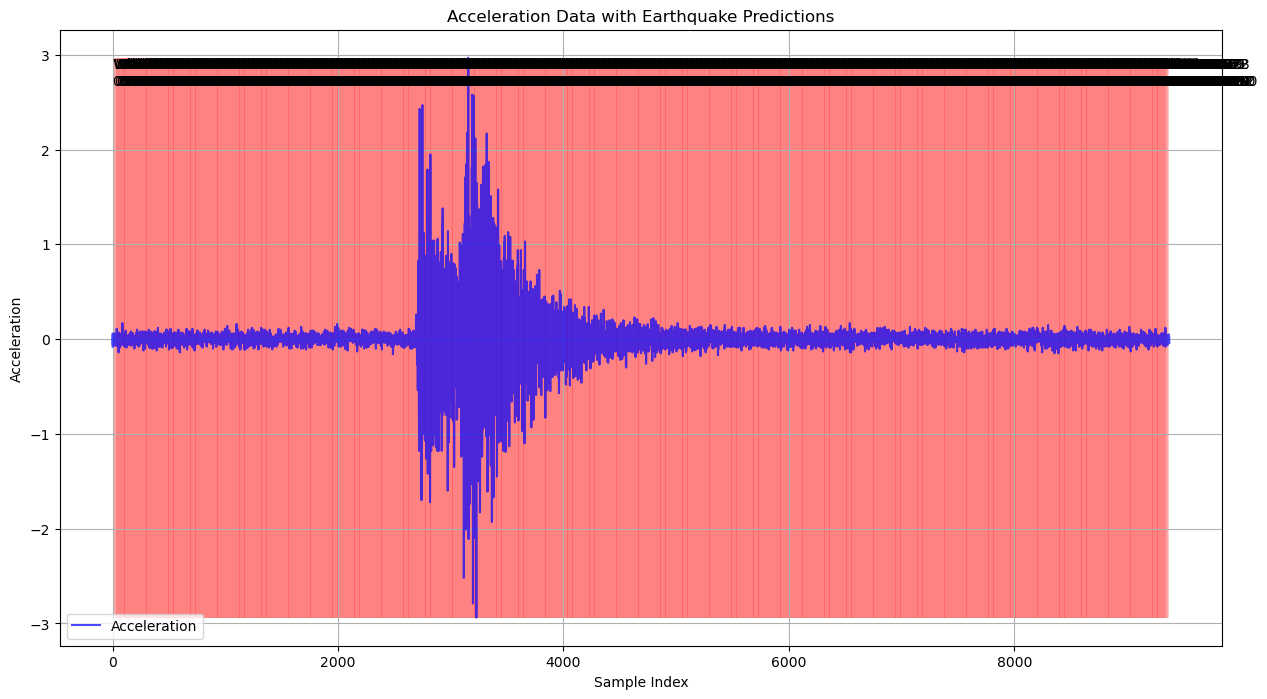

In [10]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.stats import skew, kurtosis, mode, zscore
from obspy.signal.trigger import classic_sta_lta
import pickle
import matplotlib.patches as patches

model_path = "sgd_classifier_model_updated.pkl"
scaler_path = "scaler_updated.pkl"
json_file_path = "AWS EARTHQUAKE DATASET/date=2022-01-16 time=23-31-08/005/30.jsonl"

def compute_mer(signal, window_size=50):
    energy = np.convolve(signal**2, np.ones(window_size), mode='valid')
    mer = np.zeros(len(signal))
    mer[window_size - 1: window_size - 1 + len(energy)] = energy
    return mer

def analyze_json_file(json_file_path, scaler_path, model_path):
    # Load the scaler and model
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    
    # Read JSON file
    x_data, time_data = [], []
    with open(json_file_path, "r") as file:
        for line in file:
            record = json.loads(line)
            device_time = datetime.fromtimestamp(record["device_t"])
            sr = record["sr"]
            
            time_values = [
                (device_time + timedelta(seconds=(i / sr))).strftime('%H:%M:%S.%f')[:-3] 
                for i in range(len(record["x"]))
            ]
            
            x_data.extend(record["x"])
            time_data.extend(time_values)

    x_data = np.array(x_data)
    time_data = np.array(time_data)
    
    # Compute STA/LTA
    sta_window = int(1 * sr)
    lta_window = int(10 * sr)
    sta_lta_x = classic_sta_lta(x_data, sta_window, lta_window)
    
    # Compute MER
    mer_x = compute_mer(x_data, window_size=50)
    
    # Sliding window parameters
    before_duration = int(1 * sr)  # 1 sec
    after_duration = int(0.5 * sr)  # 0.5 sec
    step_size = int(0.5 * sr)  # Move by 0.5 sec each step
    window_size = before_duration + after_duration
    
    # Store results
    results = []
    predictions = []
    window_indices = []
    window_times = []
    window_ranges = []
    
    def compute_stats(data, sta_lta, mer):
        if len(data) == 0:
            return [np.nan] * 14
        
        mode_value = mode(data, keepdims=True)[0]
        return [
            np.mean(data), np.median(data), mode_value[0] if mode_value.size > 0 else np.nan,
            np.std(data), skew(data), kurtosis(data), np.var(data), np.max(data),
            np.min(data), np.mean(zscore(data)), np.mean(sta_lta), np.max(sta_lta),
            np.mean(mer), np.max(mer)
        ]
    
    window_index = 1
    start_idx = 0
    
    while start_idx + window_size <= len(x_data):
        window_start_time = time_data[start_idx]
        
        before_data = x_data[start_idx:start_idx + before_duration]
        after_data = x_data[start_idx + before_duration:start_idx + window_size]
        before_sta_lta = sta_lta_x[start_idx:start_idx + before_duration]
        after_sta_lta = sta_lta_x[start_idx + before_duration:start_idx + window_size]
        before_mer = mer_x[start_idx:start_idx + before_duration]
        after_mer = mer_x[start_idx + before_duration:start_idx + window_size]
        
        before_stats = compute_stats(before_data, before_sta_lta, before_mer)
        after_stats = compute_stats(after_data, after_sta_lta, after_mer)
        
        # Combine stats and scale them
        combined_stats = np.array(before_stats + after_stats).reshape(1, -1)
        scaled_stats = scaler.transform(combined_stats)
        
        # Make prediction
        prediction = model.predict(scaled_stats)[0]
        
        results.append(before_stats + after_stats)
        predictions.append(prediction)
        window_indices.append(window_index)
        window_times.append(window_start_time)
        window_ranges.append((start_idx, start_idx + window_size))
        
        window_index += 1
        start_idx += step_size
    
    # Create visualization
    plt.figure(figsize=(15, 8))
    
    # Plot acceleration data
    plt.plot(range(len(x_data)), x_data, 'b-', label='Acceleration', alpha=0.7)
    
    # Highlight windows with earthquake predictions
    for idx, pred, w_range, w_index, w_time in zip(range(len(predictions)), predictions, window_ranges, window_indices, window_times):
        if pred == 1:
            start, end = w_range
            rect = patches.Rectangle((start, min(x_data)), end - start, max(x_data) - min(x_data),
                                  facecolor='red', alpha=0.2)
            plt.gca().add_patch(rect)
            plt.text(start, max(x_data), f'Window {w_index}\n{w_time}',
                    verticalalignment='top')
    
    plt.xlabel('Sample Index')
    plt.ylabel('Acceleration')
    plt.title('Acceleration Data with Earthquake Predictions')
    plt.legend()
    plt.grid(True)
    
    return results, predictions, window_indices, window_times


model_path = "sgd_classifier_model_updated.pkl"
scaler_path = "scaler_updated.pkl"
json_file_path = "AWS EARTHQUAKE DATASET/date=2022-01-16 time=23-31-08/005/30.jsonl"


# Example usage:
results, predictions, indices, times = analyze_json_file(
    json_file_path,scaler_path, model_path)


In [11]:
results

[[0.004516129032258064,
  0.01,
  0.05,
  0.04094360477672164,
  -0.4948589274036087,
  -0.810908592809906,
  0.001676378772112383,
  0.06,
  -0.08,
  -1.0744093786695063e-17,
  0.0,
  0.0,
  0.0,
  0.0,
  0.006,
  0.0,
  0.02,
  0.05057008338270102,
  0.4604848456023656,
  -0.5393701729186544,
  0.0025573333333333338,
  0.11,
  -0.07,
  -2.960594732333751e-17,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.005161290322580645,
  0.0,
  0.0,
  0.04492796871135636,
  0.27419287232736944,
  -0.48928199682704276,
  0.002018522372528616,
  0.11,
  -0.07,
  5.0139104337910294e-17,
  0.0,
  0.0,
  0.0,
  0.0,
  -0.013333333333333334,
  -0.01,
  -0.03,
  0.05120763831912406,
  -0.9240102792071183,
  0.6221488078138471,
  0.002622222222222223,
  0.07,
  -0.14,
  2.2204460492503132e-17,
  0.0,
  0.0,
  0.08242666666666666,
  0.11250000000000002],
 [-0.004193548387096774,
  -0.01,
  0.02,
  0.05103914965089416,
  -0.2117511462130207,
  0.6289127157761305,
  0.002604994797086369,
  0.11,
  -0.14,
  -1.790682297